# hopfield

> Implementation of binary Hopfield Networks and Dense Associative Memories.

In this module we implement classical binary Hopfield Networks as well as Dense Associative Memories, which are
both forms of *energy-based Associative Memories*. Energy-based Associative Memories (AMs) are recursive neural networks
which are content-addressable memories. The main bulk of the module is implemented using the tutorial at [https://tutorial.amemory.net/tutorial/dense_storage.html]()
as a reference. Please read this first, as it contains much more information, and the implementation is largely identical in layout and function.

In [ ]:
# | default_exp hopfield

In [ ]:
# | hide
from nbdev.showdoc import *

In [ ]:
# | hide
# | export
import os

import equinox as eqx
import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
from beartype import beartype as typechecker
from beartype import typing as T
from einops import rearrange
from fastcore.basics import *
from fastcore.meta import *
from jaxtyping import Array, Float, jaxtyped


In [ ]:
# | hide
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Generic Hopfield Networks

In it's most generic case, defining an associative memory in the Hopfield network-style requires only one thing: defining an *energy function*.
An energy function $E$ is a function of the parameters of the network to a real number $x$, ideally a measure of the global similarity
between the query state $\xi$ and the stored traces $\Xi$. As we do asynchronous recall with an energy-based AM, the network iteratively
reduces the energy of the query state by randomly "flipping a bit" of the query state, iff flipping that bit *reduces the energy* of the query
state.

There are other important properties of the energy function of a Hopfield network: namely, that it is *convex*. Convexity
of the function guarantees that there is some local minima in the "energy landscape" (the range of the energy-function). Local
minima in the energy landscape are ideally equivalent to stored patterns in the network: however, if the AM reaches *critical capacity*,
then the local minima of the state do not correspond to the stored patterns. These states are called *spurious states*. Cognitively speaking,
these can be situations in which there is some kind of error in recall, giving us a pattern which is unintelligible.

In [ ]:
# | export
@jaxtyped(typechecker=typechecker)
class GenericAM(eqx.Module):
    Xi: Float[Array, "K D"]  # The stored patterns

    def energy(self, query: Float[Array, " D"]) -> float:
        """Compute the energy of the `query` state."""
        # Left to be implemented by sub-classes.
        ...

    def async_update(self, current_query_state: Float[Array, " D"], idx: int):
        """Flip a bit in the current query state at given index if it lowers the energy."""
        flipped_query_state = current_query_state.at[idx].multiply(-1)
        current_query_energy = self.energy(current_query_state)
        flipped_query_energy = self.energy(flipped_query_state)
        does_flip_reduce_energy = (flipped_query_energy - current_query_energy) < 0
        return lax.cond(
            does_flip_reduce_energy,
            lambda: (flipped_query_state, flipped_query_energy),
            lambda: (current_query_state, current_query_energy),
        )

    @eqx.filter_jit
    def async_recall(
        self,
        initial_query_state: Float[Array, " D"],
        nsteps: int = 20_000,
        key: jax.Array = jr.PRNGKey(0),
    ):
        """Iteratively update the initial query state in order to reduce its energy."""

        def update_step(query_state, idx):
            new_query_state, new_query_energy = self.async_update(query_state, idx)
            return new_query_state, (new_query_state, new_query_energy)

        D = initial_query_state.shape[-1]
        seq = jr.choice(key, np.arange(D), shape=(nsteps,))
        final_query_state, (frames, energies) = lax.scan(
            update_step, initial_query_state, seq
        )
        return final_query_state, (frames, energies)

****************************************************************************
* hwloc 2.0.3 received invalid information from the operating system.
*
* Failed with: intersection without inclusion
* while inserting Group0 (P#16 cpuset 0x00000f00) at L1d (P#16 cpuset 0x00000104)
* coming from: linux:sysfs:cluster
*
* The following FAQ entry in the hwloc documentation may help:
*   What should I do when hwloc reports "operating system" warnings?
* Otherwise please report this error message to the hwloc user's mailing list,
* along with the files generated by the hwloc-gather-topology script.
* 
* hwloc will now ignore this invalid topology information and continue.
****************************************************************************


The two important functions here are `GenericAM.async_update` and `GenericAM.async_recall`:

In [ ]:
show_doc(GenericAM.async_update)

---

### GenericAM.async_update

>      GenericAM.async_update (current_query_state:jaxtyping.Float[Array,'D'],
>                              idx:int)

*Flip a bit in the current query state at given index if it lowers the energy.*

In [ ]:
show_doc(GenericAM.async_recall)

---

### GenericAM.async_recall

>      GenericAM.async_recall (initial_query_state:jaxtyping.Float[Array,'D'],
>                              nsteps:int=20000, key:jax.Array=Array([0, 0],
>                              dtype=uint32))

*Iteratively update the initial query state in order to reduce its energy.*

# Classical Hopfield Network

The Classical Hopfield network is the energy-based AM that was first proposed in [Hopfield (1982)](https://www.pnas.org/doi/10.1073/pnas.79.8.2554) and [Hopfield (1984)](https://pubmed.ncbi.nlm.nih.gov/6587342/).
It has an energy function which describes the dot-product between the query state and the stored patterns in the associative memory:
$$
E_\text{CHN}(\sigma) = - \frac{1}{2} \sum_{\mu} \left( \sum_i \xi^\mu_i \sigma_i \right)^2,
\tag{1}
$$
where each $\xi^\mu$ is a stored pattern.

In [ ]:
# | export
@jaxtyped(typechecker=typechecker)
class ClassicalHopfield(GenericAM):
    """Classical Hopfield Network defined by the energy function
    in equation (1).
    """

    def energy(self, query: Float[Array, " D"]) -> float:
        return -0.5 * jnp.sum((self.Xi @ query) ** 2, axis=0)

In [ ]:
show_doc(ClassicalHopfield.energy)

---

### ClassicalHopfield.energy

>      ClassicalHopfield.energy (query:jaxtyping.Float[Array,'D'])

*Compute the energy of the `query` state.*

## Example

In order to demonstrate the efficacy (and shortcomings) of the classical Hopfield Network, we will do a simple recall task using the MNIST dataset.

In [ ]:
DATA_DIR = "../data/mnist"

pxw, pxh = 28, 28


def transform(data):
    data = np.array(data, dtype=jnp.float32)
    data = rearrange(data, "w h -> (w h)")
    data[data > 0.0] = 1.0
    data[data == 0.0] = -1.0
    return data


mnist_train = MNIST(DATA_DIR, train=True, transform=transform)
mnist_data_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
mnist_it = iter(mnist_data_loader)
mnist_data, _ = next(mnist_it)

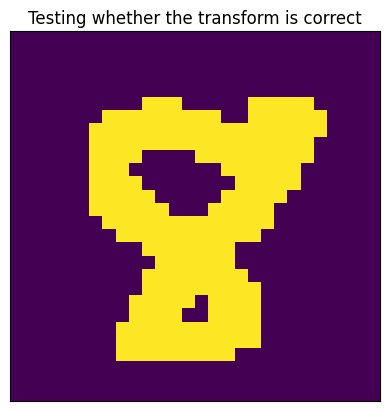

In [ ]:
def show_im(im: Float[Array, " WH"], title: str = "") -> None:
    im = rearrange(im, "(w h) -> w h", w=pxw, h=pxh)
    plt.imshow(im)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])


show_im(mnist_data[0], title="Testing whether the transform is correct")

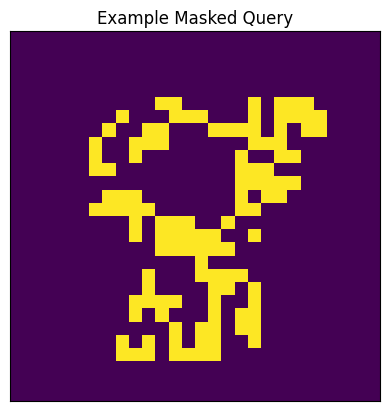

In [ ]:
def mask(
    state: Float[Array, " D"], pct_mask: float = 0.5, key: jax.Array = jr.PRNGKey(0)
) -> Float[Array, " D"]:
    D = state.shape[-1]
    bits_to_mask = jr.choice(key, np.arange(D), shape=(int(D * pct_mask),))
    return state.at[bits_to_mask].set(-1.0)


show_im(
    mask(jnp.array(mnist_data[0], dtype=jnp.float32), 0.5), title="Example Masked Query"
)

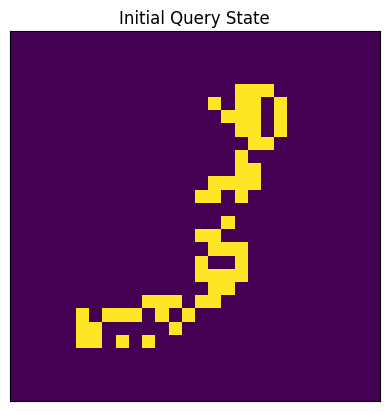

In [ ]:
def iterate_recall(
    am: GenericAM,
    query_state: Float[Array, " D"],
    save: bool = True,
    key: jax.Array = jr.PRNGKey(0),
    **kwargs,
):
    final_query_state, (frames, energies) = am.async_recall(
        query_state, key=key, **kwargs
    )
    return final_query_state, (frames, energies)


Xi = jnp.array(mnist_data[:2], dtype=jnp.float32)
chn = ClassicalHopfield(Xi)
query = Xi[1]
masked_query = mask(query)
final_query_state, (frames, energies) = iterate_recall(chn, masked_query)

show_im(masked_query, "Initial Query State")

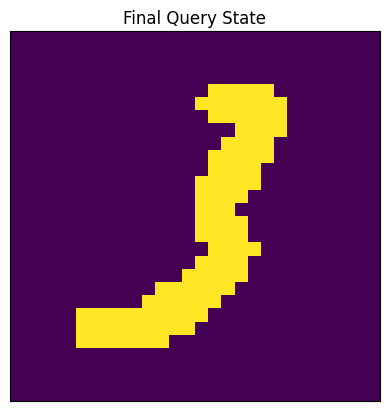

In [ ]:
show_im(final_query_state, "Final Query State")

We can also plot out the energy of the network over time:

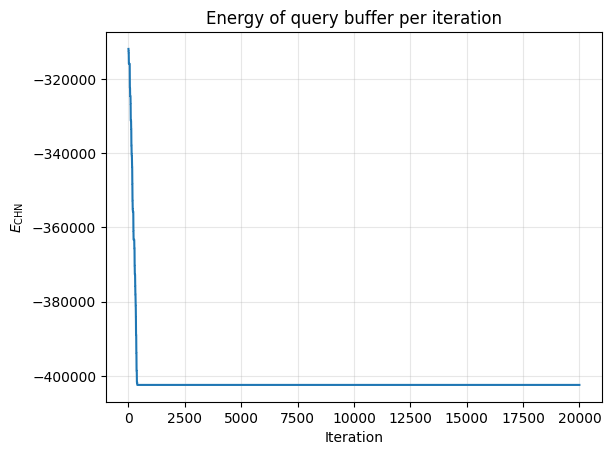

In [ ]:
plt.plot(energies)
plt.title("Energy of query buffer per iteration")
plt.grid(True, alpha=0.3)
plt.xlabel("Iteration")
plt.ylabel(r"$E_\text{CHN}$")
plt.show()

To demonstrate the low critical capacity of this associative memory, we really only need to introduce
one more pattern:

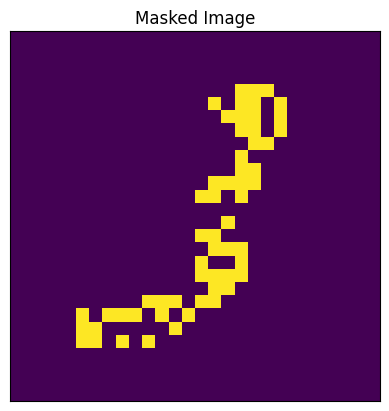

In [ ]:
Xi = jnp.array(mnist_data[:3])
chn = ClassicalHopfield(Xi)
query = Xi[1]
masked_query = mask(query)
final_query_state, (frames, energies) = iterate_recall(chn, masked_query)
show_im(masked_query, "Masked Image")

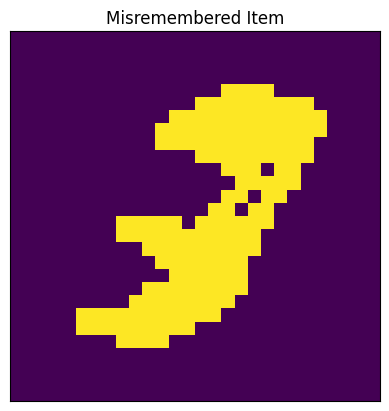

In [ ]:
show_im(final_query_state, "Misremembered Item")

This is what I call the *omnidigit*. There is some interesting research pointing towards the shift
between generative capacities and memory capacities after AMs reach their critical capacity, 
e.g. [Pham, *et al.* (2025)](https://arxiv.org/abs/2505.21777) and a worked out tutorial [here](https://tutorial.amemory.net/tutorial/diffusion_as_memory.html). But, we will not be covering this here.

# Dense Associative Memories

While Hopfield networks are a wonderful discovery, they have a severe limitation.
Their *critical capacity* is, famously, around $0.14 N$, where $N$ is the number of patterns
stored in the network. To overcome this, a general framework for associative memories, called
*Dense Associative Memories* (DAMs) was proposed in [Krotov & Hopfield (2016)](https://arxiv.org/abs/1606.01164).
The key intuition behind the increased capacity is to maximize the *separation* of stored patterns
in memory [Millidge, *et al.* (2022)](https://arxiv.org/abs/2202.04557). Recall, energy-based AMs
"misremember" stored patterns whenever the local minima of the energy landscape become conjoined,
i.e. the minima do not correspond with the intended stored patterns. Thus, to increase the capacity,
we need to increase the distance between stored patterns. In order to do this, Krotov & Hopfield (2016) found
that if we introduce a non-linearity into the energy function then we can make the network
"emphasize" high-similarities between the query vector and stored patterns, and further
"de-emphasize" low similarity values. 

Single-shot AMs, which learn in one non-asynchronous pass, that perform similar operations will be discussed
in `01_minerva.ipynb`.

In [ ]:
# | export
@jaxtyped(typechecker=typechecker)
class DAM(GenericAM):
    """Dense Associative Memory."""

    Xi: Float[Array, "K D"]  # The stored patterns
    polynomial: (
        int  # The polynomial to use to increase the separation in the energy function.
    )
    rectified: bool = True  # Whether or not the energy function is rectified.

    def F_n(
        self,
        sims: Float[Array, " D"],  # The dot-product similarity scores
    ):
        """The polynomial function inside of the energy function."""
        sims = sims.clip(0.0) if self.rectified else sims
        return 1 / self.polynomial * sims**self.polynomial

    def energy(self, query_state: Float[Array, " D"]) -> float:
        return -jnp.sum(self.F_n(self.Xi @ query_state))

The important function here is, of course, the *energy* function:

In [ ]:
show_doc(DAM.energy)

---

### DAM.energy

>      DAM.energy (query_state:jaxtyping.Float[Array,'D'])

*Compute the energy of the `query` state.*

The energy function takes on the general form of:
$$
E_\text{DAM}(\sigma) =  - \sum_\mu \left( \sum_i F_n (\xi^\mu_i \sigma_i) \right),
\tag{2}
$$
where $F_n$ is the polynomial of order $n$, which increases separation.


In [ ]:
show_doc(DAM.F_n)

---

### DAM.F_n

>      DAM.F_n (sims:jaxtyping.Float[Array,'D'])

*The polynomial function inside of the energy function.*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| sims | Float[Array, 'D'] | The dot-product similarity scores |

## Example

Like we did with the Classical Hopfield network, we will also show an example. This time, however,
we will include a lot more stored patterns in order to demonstrate that the 
associative memory has a higher critical capacity.

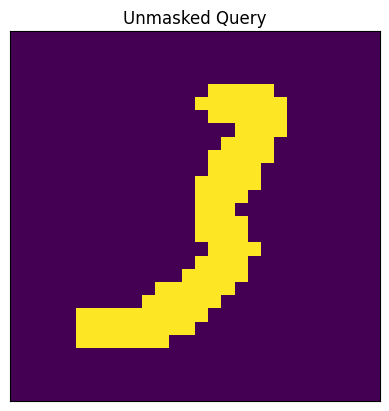

In [ ]:
Xi = jnp.array(mnist_data[:10])
dam = DAM(Xi, polynomial=6, rectified=True)
query = Xi[1]
show_im(query, "Unmasked Query")

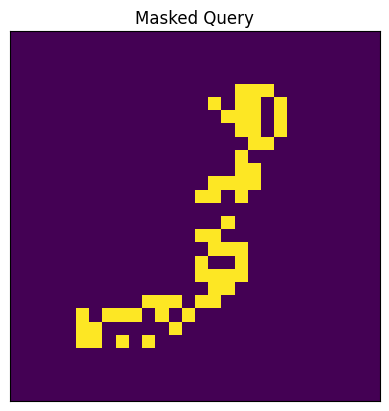

In [ ]:
masked_query = mask(query)
show_im(masked_query, "Masked Query")

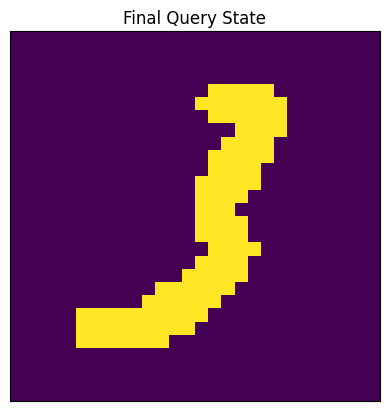

In [ ]:
final_query_state, (frames, energies) = iterate_recall(dam, masked_query)
show_im(final_query_state, "Final Query State")

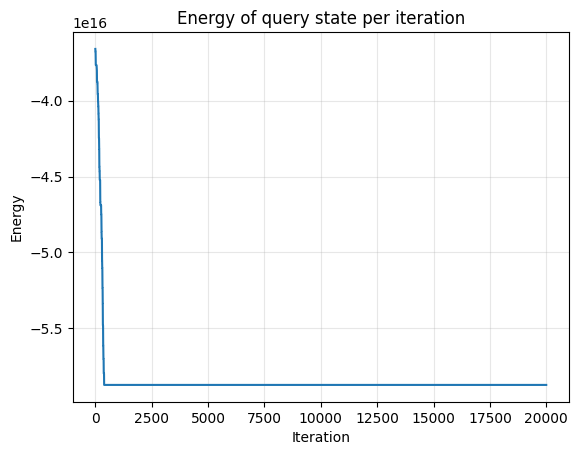

In [ ]:
plt.plot(energies)
plt.title("Energy of query state per iteration")
plt.grid(True, alpha=0.3)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.show()

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()